# Getting started with Alfa

In this notebook you will generate a mock spectrum based on an SSP model. Fitting is done form running a command line argument inside this notebook. Once the fits are completed, you will learn how to read in the output files and generate burn-in plots, corner plots, and plot up the best-fit models compared to the mock data.

In [25]:
from alfa.grids import Grids
from alfa.read_data import Data
from alfa.polynorm import polynorm
from alfa.setup_params import setup_params, get_properties
import numpy as np
import time
from scipy.stats import norm
from astropy.table import Table
import matplotlib.pyplot as plt
import emcee

In [2]:
# load grid of models
t1 = time.time()
g = Grids(kroupa_shortcut = False)
t2 = time.time()

print(f'time to load: {t2-t1:.1f}s')

Smoothing grids to instrumental resolution = 0.0 km/s
time to load: 10.3s


In [3]:
# which parameters do you want to include? Parameters not included will be set to default values
parameters_to_fit = ['velz', 'sigma', 'logage', 'zH', 'feh', 'ah', 'ch', 
                'nh', 'nah', 'mgh', 'sih', 'kh', 'cah', 'tih', 'vh', 
                'crh']

parameters_to_fit = ['velz', 'sigma', 'logage', 'zH', 'feh', 'mgh', 'cah']

pos, priors = setup_params(parameters_to_fit)
params = get_properties(pos, parameters_to_fit)

params['sigma'] = 200
params['logage'] = np.log10(5)
params['zH'] = -0.12
params['feh'] = -0.02
params['mgh'] = 0.11
print(f'Input parameters = {params}')

Input parameters = {'velz': 0, 'sigma': 200, 'logage': 0.6989700043360189, 'zH': -0.12, 'feh': -0.02, 'mgh': 0.11, 'cah': 0}


In [183]:
# define funcitons required to generate mock spectra
def add_noise(spec,s2n):
    noise = np.mean(spec)/s2n
    random_numbers = np.random.uniform(size = len(spec))
    spec_with_noise = spec + [norm.ppf(random_numbers[i],
                                loc=0,scale=noise)
                                for i in range(len(random_numbers))]
    return spec_with_noise, noise


def write_file(filename,wave,flux,noise,fitrgs = [[0.38,0.47],[0.47,0.56]]):
    s = np.ones(len(wave))
    inst_res = np.zeros(len(wave))
    
    tab = Table([wave,flux,noise,s.astype(int),inst_res])

    header = ''
    for fr in fitrgs:
        header +='{0:.4f} {1:.4f}\n'.format(fr[0],fr[1])
    
    np.savetxt(filename,tab,
               header = header[:-1],
                   fmt='%11.3f %11.3e %11.3e %11.1f %11.2f')



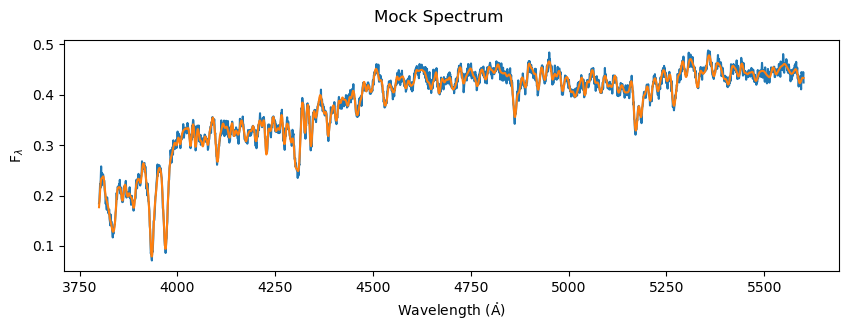

In [190]:
import random
random.seed(69)

# save name
filename = 'indata/mock_spectrum.dat'

# fitting regions:
fitrgs = np.array([[3800, 4700],
                   [4700, 5700],
                   [5700, 6400],
                   [8000, 8800]])

fitrgs = np.array([[3800,4700],
                   [4700,5600]])

wave_min, wave_max = np.min(fitrgs)-1, np.max(fitrgs)+1

# generate model
m_spec = g.get_model(params)
m_spec = m_spec[(g.ssp.wave>wave_min)&(g.ssp.wave<wave_max)]
wave = g.ssp.wave[(g.ssp.wave>wave_min)&(g.ssp.wave<wave_max)]

# how much noise?
s2n_perAA = 50
s2n_perPix = s2n_perAA*np.sqrt(0.9)

spec_noise, noise = add_noise(m_spec, s2n = s2n_perPix)

write_file(filename,
       wave,spec_noise,noise*np.ones(len(m_spec)), fitrgs = fitrgs/1e4)

plt.figure(figsize=(10,3))
plt.suptitle('Mock Spectrum')
plt.plot(wave,spec_noise)
plt.plot(wave,m_spec)
plt.xlabel('Wavelength ($\mathring{\mathrm{A}}$)')
plt.ylabel('F$_\lambda$')
plt.show()

# Run Alfa

In [176]:
!caffeinate python alfa/alfa.py mock_spectrum

Loading mock_spectrum_simple...
Loading grids...
Smoothing grids to instrumental resolution = 0.0 km/s
fitting with emcee...
100%|███████████████████████████████████████| 1000/1000 [04:24<00:00,  3.78it/s]


# Post-Processing
Once complete, read in the MCMC walker file. Take a look at the burn-in and corner plots

In [177]:
# read-in walker file
reader = emcee.backends.HDFBackend(f'outfiles/mock_spectrum.h5')

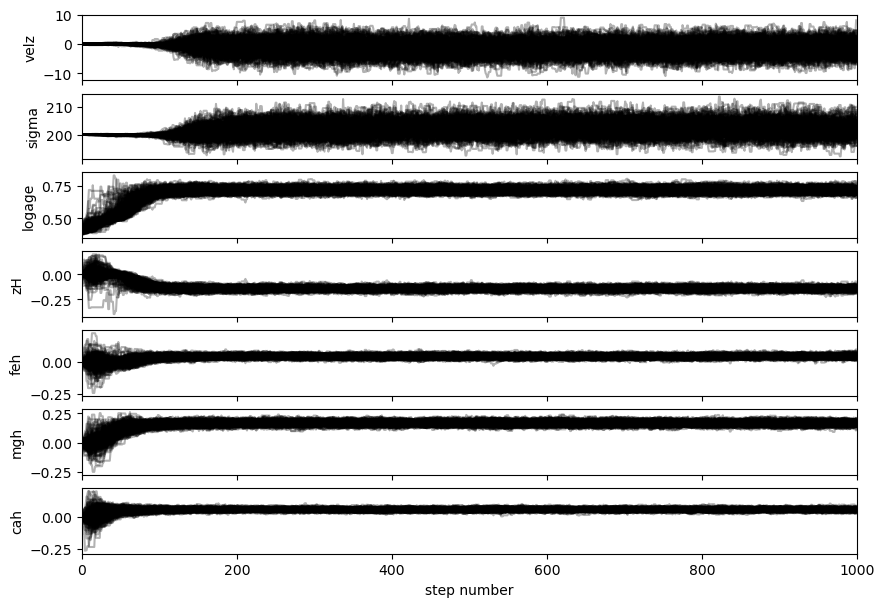

In [178]:
# plot burn in steps
samples = reader.get_chain(flat=False, thin=1,discard=0)
ndim = samples.shape[2]
fig, axes = plt.subplots(len(parameters_to_fit), figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(parameters_to_fit[i])
    # ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

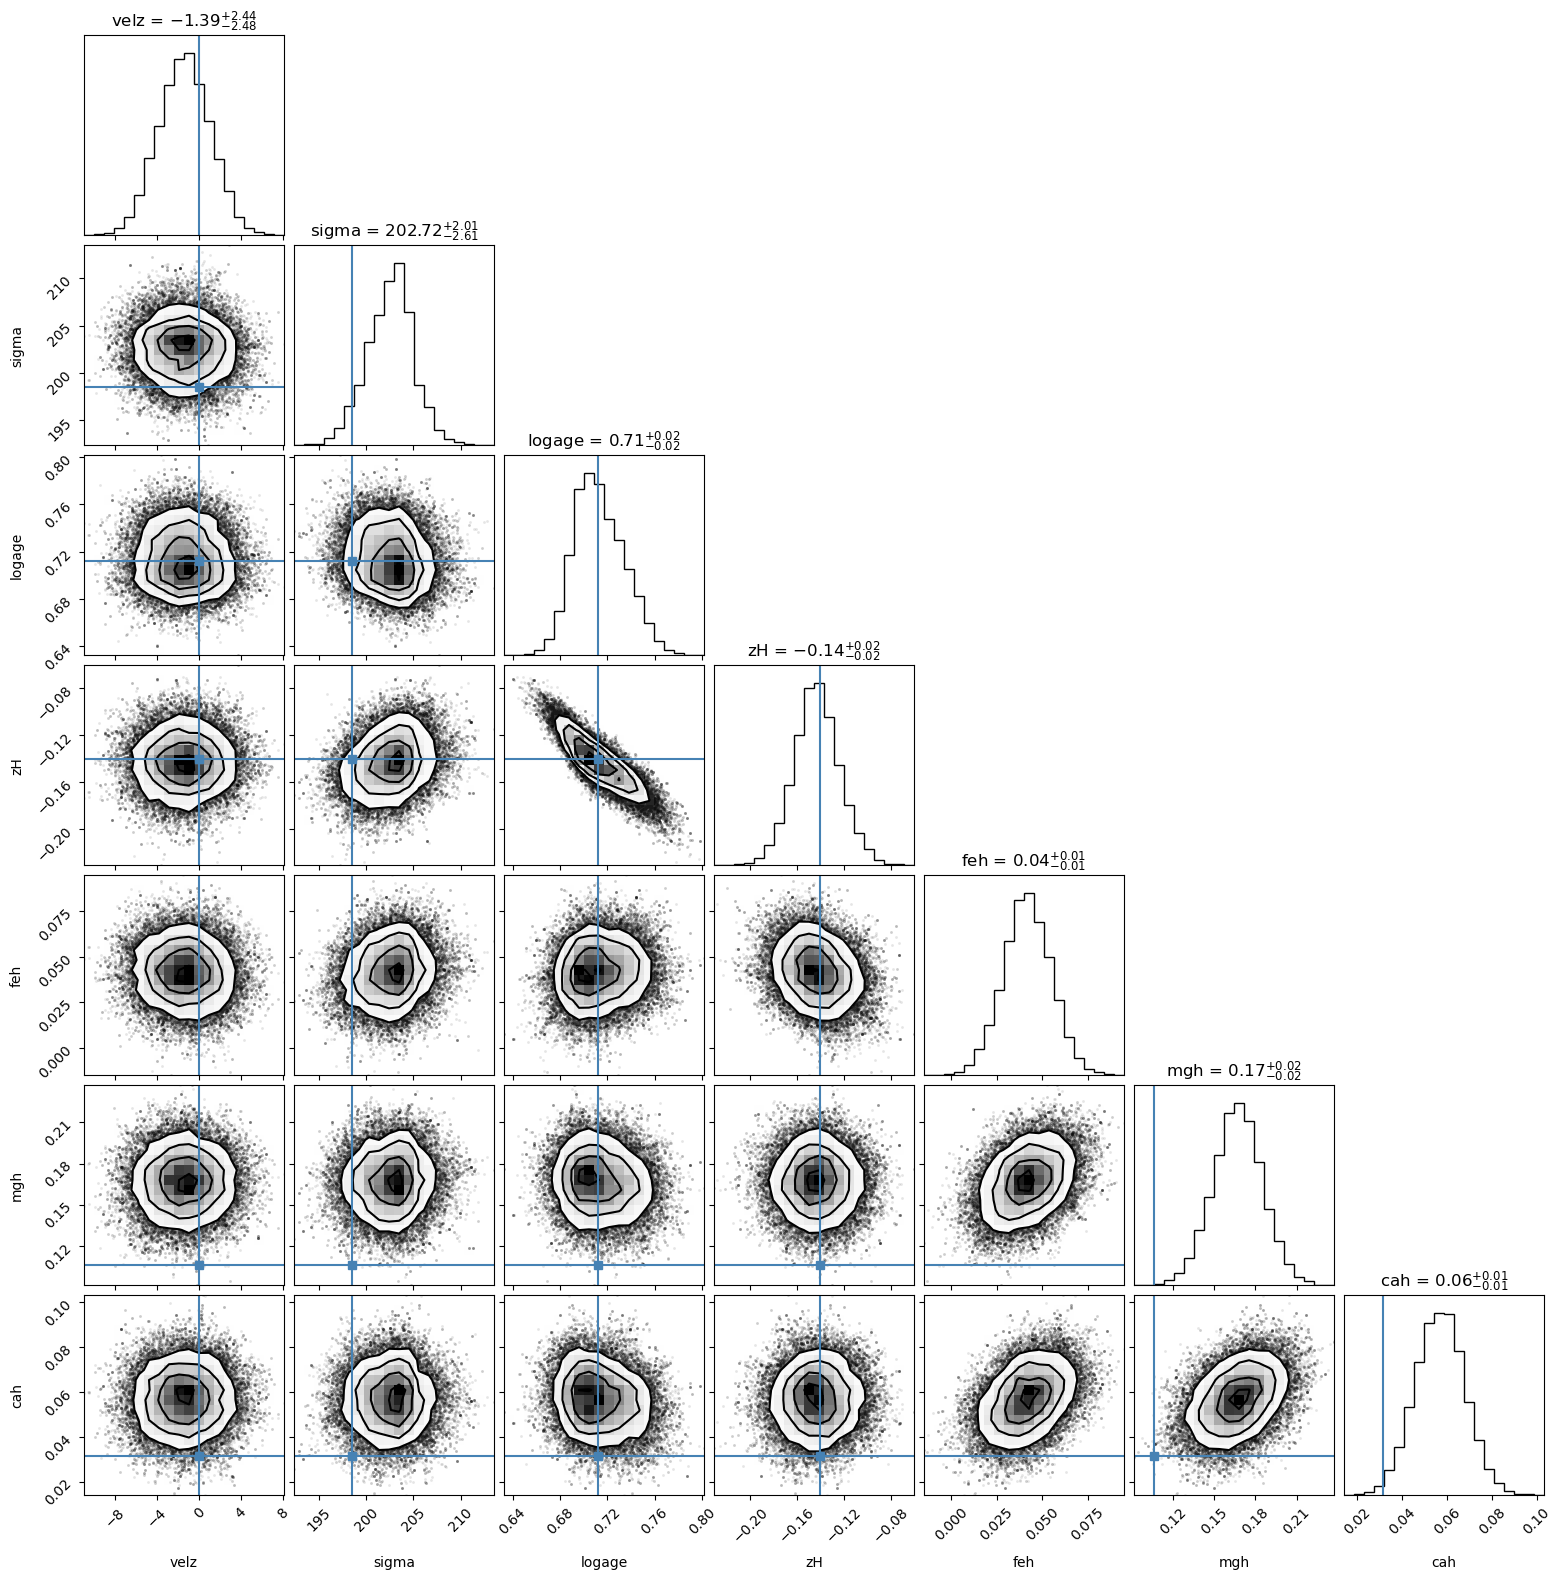

In [179]:
#plot corner
import corner

flat_samples = reader.get_chain(discard=700,flat=True, thin=1)

# corner plot
sel = np.ones(len(parameters_to_fit)).astype(bool)
fig = corner.corner(
    flat_samples[:,sel], labels=np.array(parameters_to_fit)[sel],truths = np.array(list(params.values()))[sel],show_titles=True
)

# Take a look at the best-fit spectra

Text(0, 0.5, 'Flux')

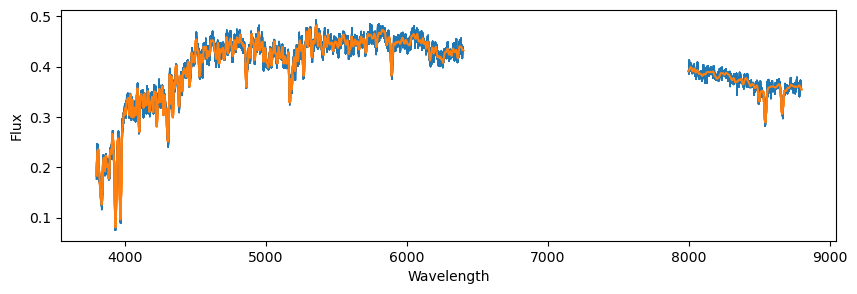

In [191]:
data = Data('indata/mock_spectrum',filename_exact=True)

plt.figure(figsize=(10,3))
inds = np.random.randint(len(flat_samples), size=10)
for ind in inds:
    sample = flat_samples[ind]
    
    params = get_properties(sample,parameters_to_fit)
    mflux = g.get_model(params,outwave=data.wave)

    #poly norm
    poly, mfluxnorm, data_r = polynorm(data, mflux,return_data=True)
    plt.plot(data.wave,data_r, 'C0', lw=1)
    plt.plot(data.wave,mfluxnorm, 'C1')
    

plt.xlabel('Wavelength')
plt.ylabel('Flux')